In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [2]:
# Importing our data
data = pd.read_excel('table_8_offenses_known_to_law_enforcement_washington_by_city_2013.xls', 
                     encoding='latin1', skiprows=list(range(4)))
# Condense and clean our dataset
data = data.rename(index = str, columns={'Murder and\nnonnegligent\nmanslaughter': 'Murder', 'Property\ncrime': "Property_crime"})
data = data[['Population', 'Murder', 'Robbery', 'Property_crime', 'Burglary']]
data = data[data.Population < 250000]
data = data.dropna()

# Create the new rows for our regression model
data['Pop_squared'] = data['Population']**2

# Preview the data
data.head()

,Population,Murder,Robbery,Property_crime,Burglary,Pop_squared
0,16408.000,0.000,13.000,944.000,208.000,269222464.000
1,6441.000,0.000,6.000,333.000,72.000,41486481.000
2,3123.000,0.000,0.000,73.000,22.000,9753129.000
3,15980.000,0.000,3.000,559.000,127.000,255360400.000
4,18425.000,0.000,11.000,1124.000,198.000,339480625.000


In [3]:
# View the column statistics
data.describe()

,Population,Murder,Robbery,Property_crime,Burglary,Pop_squared
count,181.000,181.000,181.000,181.000,181.000,181.000
mean,19673.442,0.448,18.884,865.072,168.746,1458787702.304
std,32828.304,1.485,61.213,2077.921,420.668,5345075325.435
min,278.000,0.000,0.000,0.000,0.000,77284.000
25%,2759.000,0.000,0.000,53.000,11.000,7612081.000
50%,7342.000,0.000,2.000,247.000,47.000,53904964.000
75%,19765.000,0.000,9.000,671.000,129.000,390655225.000
max,209524.000,11.000,524.000,19531.000,3889.000,43900306576.000


In [4]:
# Construct our linear regression model with our X variables 
# and predict Y
regr = linear_model.LinearRegression()
X = data[['Population', 'Murder', 'Robbery', 'Pop_squared']]
Y = data['Property_crime'].values.reshape(-1, 1)
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[ 2.09086995e-02  2.88449857e+01  2.33047985e+01 -9.60702777e-09]]

Intercept: 
 [14.74452119]

R-squared:
0.9568921189616915


In [5]:
# Review the correlation matrix
correlation_matrix = X.corr()
display(correlation_matrix)

,Population,Murder,Robbery,Pop_squared
Population,1.000,0.757,0.857,0.915
Murder,0.757,1.000,0.851,0.790
Robbery,0.857,0.851,1.000,0.936
Pop_squared,0.915,0.790,0.936,1.000


# PCA

In [6]:
pca = PCA(n_components=1)
X = StandardScaler().fit_transform(X)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1'])
principalDf.head()

,principal component 1
0,-0.357
1,-0.589
2,-0.693
3,-0.449
4,-0.337


In [7]:
# How much of our variance do we retain after limiting our data to 1 component?
pca.explained_variance_ratio_

array([0.88897405])

In [8]:
# Create a new linear regression model with our 1 variable
X = principalDf
Y = data['Property_crime'].values.reshape(-1, 1)
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[1063.74937123]]

Intercept: 
 [865.0718232]

R-squared:
0.9370777555944841


In [9]:
# Creating our residual graph based on predicted and actual values
predicted = regr.predict(X).ravel()
target = data['Property_crime']
residual = target - predicted

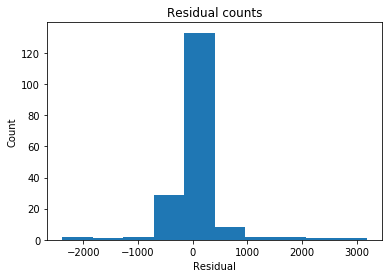

In [10]:
# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

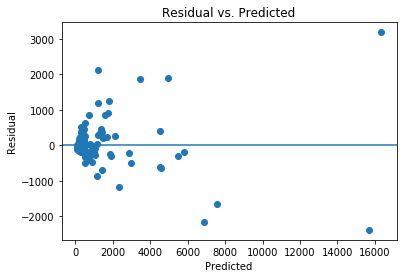

In [11]:
# Create our residual graph
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

# Cross Validation

In [12]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split

# Create our model distribution
bnb = BernoulliNB()
y_pred = bnb.fit(data, target).predict(data)

# Create cross validation with 5 groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.20)
print('With 20% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data, target).score(data, target)))

With 20% Holdout: 0.02702702702702703
Testing on Sample: 0.049723756906077346
